In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 51.9 MB/s 
     |████████████████████████████████| 895 kB 59.0 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 1.2 MB 5.0 MB/s 


In [ ]:
# # Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import copy
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import optim
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the paraphrase training, dev, and test sets previously created
paraphrase_train = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_train.csv")
paraphrase_train.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_dev = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_dev.csv")
paraphrase_dev.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_test = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_test.csv")
paraphrase_test.drop(columns={"Unnamed: 0"}, inplace=True)

In [ ]:
paraphrase_train.head()

,sentence_1,sentence_2,label,language_task
0,इससे पहले के दो मैचों में मुझे बल्लेबाजी के ल...,जवाब में पाकिस्तान की टीम मात्र एक सौ उन्सत्तर...,0,translate English to Hindi
1,ക്ലൈമാക്‌സ് അവസാനം എഴുതിക്കാണിക്കുമ്പോള്‍ മാത്...,ട്രെയ്‌ലര്‍ നോക്കി സിനിമ കാണാന്‍ ഇറങ്ങിയാല്‍ ഇ...,0,translate English to Malayalam
2,தாவூத் இப்ராகிம் - மராட்டிய மந்திரி இடையே போனி...,நிழல் உலக தாதா தாவூத் இப்ராகிம் மற்றும் மராட்ட...,1,translate English to Tamil
3,കഴിഞ്ഞ സീസണുകളില്‍ ബാറ്റ്സ്മാനെന്ന നിലയില്‍ ടീ...,സ്കോറുയർത്തുന്നതിലും പിന്തുടരുന്നതിലും ധോണി ...,0,translate English to Malayalam
4,നിയമസഭാ തെരഞ്ഞെടുപ്പില്‍ വന്‍ തിരിച്ചടിയുണ്ടായ...,തെരഞ്ഞെടുപ്പില്‍ തോറ്റതോടെ പ്രതിപക്ഷ നേതാവാകാന...,0,translate English to Malayalam


In [ ]:
# Set up the device to run on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Create an instance of the tokenizer and model using Indic Bert
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.dense.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [ ]:
# An object to split and parse the training and test data fields
class SiameseNetworkDataset(Dataset): 
  def __init__(self,training_df, device, tokenizer, model):
    self.training_df=training_df
    self.sent1 = self.training_df['sentence_1'].tolist()
    self.sent2 = self.training_df['sentence_2'].tolist()
    self.language_task = self.training_df['language_task'].tolist()
    self.label = self.training_df['label'].tolist()
    self.device = device
    self.tokenizer = tokenizer
    self.model = model

  def __getitem__(self, index):
    sent1 = self.sent1[index]
    sent2 = self.sent2[index]
    task = self.language_task[index]
    label = self.label[index]

    # Get the sentence embeddings for sentences 1 and 2 for each row
    sent1_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent1)
    sent2_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent2)
    return sent1_embeddings, sent2_embeddings, task, torch.from_numpy(np.array(label)).long()

  def __len__(self):
    return len(self.training_df)

In [ ]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data
siamese_train = SiameseNetworkDataset(paraphrase_train, device, tokenizer, model)
siamese_dev = SiameseNetworkDataset(paraphrase_dev, device, tokenizer, model)
siamese_test = SiameseNetworkDataset(paraphrase_test, device, tokenizer, model)

In [ ]:
# Get the label for every row in the training dataset and convert it to tensor form
target_list = []

for sent1, sent2, task, label in siamese_train:
  target_list.append(label)

# Store the torch form of the target label   
target_list = torch.tensor(target_list)

In [ ]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
class_count = [len(paraphrase_train[paraphrase_train.label == 0]),len(paraphrase_train[paraphrase_train.label == 1])]
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

[4500, 3000]
tensor([0.0002, 0.0003])


In [ ]:
# Create a list of the weighted labels to pass to the dataloader object
class_weights_all = class_weights[target_list]

In [ ]:
# Create the weighted sampler object to pass to the training data loader
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
# Pass the training data into the training loader 
# Don't shuffle since we pre-shuffled the data - we want to see how the model performs on specific languages
train_loader = DataLoader(siamese_train, batch_size = 16, sampler=weighted_sampler)

# Create the dev and test data loaders
val_loader = DataLoader(siamese_dev, batch_size=16)
test_loader = DataLoader(siamese_test, batch_size=16)

In [ ]:
class SiameseNet(torch.nn.Module):
    def __init__(self):
      super(SiameseNet, self).__init__()
      
      self.relu = torch.nn.ReLU(inplace=True)
      self.batch2 = torch.nn.InstanceNorm1d(2304)
      self.ffn = torch.nn.Linear(2304, 128)
      self.batch3 = torch.nn.InstanceNorm1d(128)
      self.layer_out = torch.nn.Linear(128,1)

      # Add drop out
      self.drop = torch.nn.Dropout(0.2)

    # left and right represent columns in our data
    def forward(self, left, right):

      # Get the sentence embeddings 
      u = left
      v = right

      # Get the absolute value of the difference of the vectors
      uv = torch.sub(u, v)
      uv_abs = torch.abs(uv)

      # concatenate u, v, and the absolute value of the element-wise difference between the embeddings
      x = torch.cat([u, v, uv_abs], dim=-1)

      # Normalize the concatenated batch
      x = self.batch2(x)

      # Use the relu activation function
      x = self.relu(x)

      # Pass the concatenated layers through a dense layer to reduce the dimensionality from 2304 to 128
      x = self.ffn(x)
      # Normalize the concatenated layers
      x = self.batch3(x)
      # Pass through relu activation
      x = self.relu(x)
      # Implement drop out to avoid overfitting
      x = self.drop(x)
      # Pass the output through a final dense layer
      output = self.layer_out(x)
      # Reshape the output to have the same dimension as the target labels
      output = output[:,-1,:]

      # Concatenate the 
      return output

In [ ]:
# Create an instance of the Siamese model network
# Declare Siamese Network
net = SiameseNet().to(device)

# Set the criteria for evaluation and training - use cross-entropy since we're doing classification and want to retrieve the labels
criterion = torch.nn.BCEWithLogitsLoss()

# Set the optimizer and pass to it the model parameters and learning rate
optimizer = optim.Adam(net.parameters(), lr=2e-5)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
# Create dictionaries to hold the training and validation accuracy and loss metrics at each epoch
epoch_accuracies = {
    'train': [],
    "val": []}

epoch_losses = {
    'train': [],
    "val": []}

In [ ]:
EPOCHS = 10

for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Store the epoch's training and validaion accuracies and losses
    epoch_losses['train'].append(train_epoch_loss/len(train_loader))
    epoch_losses['val'].append(val_epoch_loss/len(val_loader))
    epoch_accuracies['train'].append(train_epoch_acc/len(train_loader))
    epoch_accuracies['val'].append(val_epoch_acc/len(val_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
epoch_losses

{'train': [0.566972062531819,
  0.45305691586374475,
  0.40878023810859426,
  0.3773388130260683,
  0.35431341000838573,
  0.32734922683442325,
  0.3164525254925431,
  0.3021677743270199,
  0.2881391013481978,
  0.2705241138937631],
 'val': [0.5658375848742092,
  0.5155482050250558,
  0.4981260045486338,
  0.4857946259133956,
  0.4775875363279791,
  0.4883044270908131,
  0.4814162469962064,
  0.47773917194675,
  0.4716528312248342,
  0.4796941124341067]}

In [ ]:
print(max(epoch_accuracies.get('train')))
print(max(epoch_accuracies.get('val')))

90.1727078891258
78.5764705882353


In [ ]:
print(min(epoch_accuracies.get('train')))
print(min(epoch_accuracies.get('val')))

71.63113006396588
71.2


In [ ]:
print(min(epoch_losses.get('train')))
print(max(epoch_losses.get('train')))

0.2705241138937631
0.566972062531819


In [ ]:
print(min(epoch_losses.get('val')))
print(max(epoch_losses.get('val')))

0.4716528312248342
0.5658375848742092


In [ ]:
epoch_losses.get('val').index(min(epoch_losses.get('val')))

8

In [ ]:
epoch_accuracies.get('val').index(max(epoch_accuracies.get('val')))

8

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

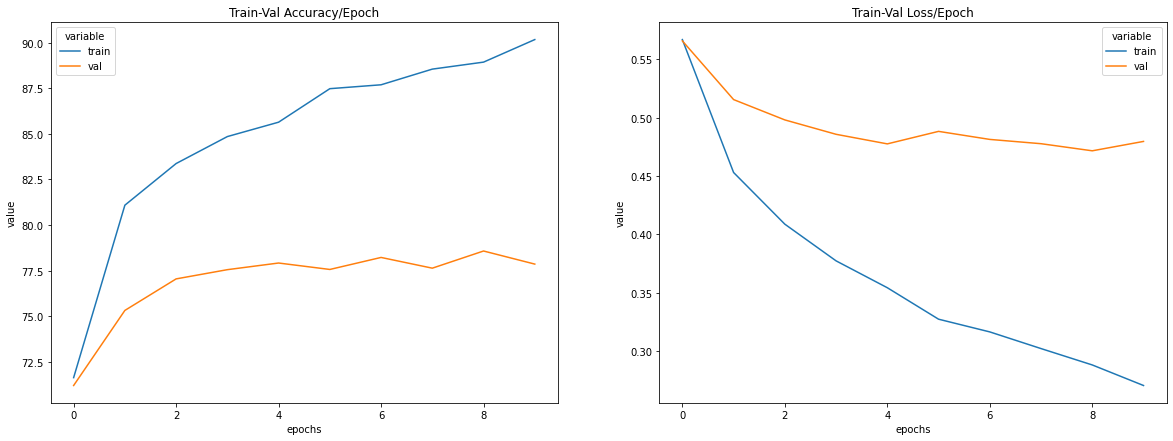

In [ ]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
# Get the test accuracy and labels
y_pred_list = []
y_actual_list = []
y_language_task = []

with torch.no_grad():

  # Place the model into evaluation mode
    net.eval()

    # Loop over the test set
    for i, data in enumerate(test_loader, 0):

      # Extract the test set components
      sent1_test, sent2_test, task_test, label_test = data

      # Store the language tasks and actual labels to check model performance
      y_actual_list.extend(label_test.tolist())
      y_language_task.extend(task_test)

      # Reshape the test label to have the same dimensions as the model output
      label_test = label_test.type(torch.FloatTensor).reshape((label_test.shape[0], 1))

      # Send the test data to GPU
      sent1_test, sent2_test, label_test = sent1_test.to(device), sent2_test.to(device), label_test.to(device)

      # Get the test set predictions
      test_pred = net(sent1_test, sent2_test)
            
      # Get the predicted test labels
      y_test_pred = torch.round(torch.sigmoid(test_pred)).long()

      # Add the test labels to their respective list
      y_pred_list.extend(y_test_pred)

In [ ]:
# Create a dataframe from test performance
y_pred = [x.item() for x in y_pred_list]
test_performance = pd.DataFrame(list(zip(y_language_task, y_actual_list, y_pred)),columns =['language', 'actual_label', 'predicted_label'])

In [ ]:
# Check the first few rows
test_performance.head()

,language,actual_label,predicted_label
0,translate English to Hindi,1,1
1,translate English to Hindi,0,0
2,translate English to Hindi,1,1
3,translate English to Hindi,1,1
4,translate English to Hindi,1,1


In [ ]:
# Get the overall accuracy rate with sklearn accuracy score
# Accuracy is approximately 76%
accuracy_score(y_actual_list, y_pred)

0.7570370370370371

In [ ]:
# Get the overall f1-score
f1_score(y_actual_list, y_pred)

0.718213058419244

In [ ]:
# Get the accuracy scores on Hindi
hi_test = test_performance[test_performance.language == 'translate English to Hindi']
# The model performs very well on Hindi
print(accuracy_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))

0.8466666666666667
0.8376470588235294


In [ ]:
# Get the accuracy scores on Tamil
ta_test = test_performance[test_performance.language == 'translate English to Tamil']
# The model performs very well on Hindi
print(accuracy_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))

0.6333333333333333
0.5132743362831859


In [ ]:
# Get the accuracy scores on Malayalam
ml_test = test_performance[test_performance.language == 'translate English to Malayalam']
# The model performs very well on Hindi
print(accuracy_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))

0.7911111111111111
0.765


In [ ]:
# Let's see the number of mistakes the model is making (on what language tasks)
cm = confusion_matrix(y_actual_list, y_pred)

# Create and apply a mask to ignore the diagonal entries (these are correctly predicted values)
cm

array([[604, 129],
       [199, 418]])

In [ ]:
# Check the confusiom matrix on Hindi
confusion_matrix(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist())

array([[203,  51],
       [ 18, 178]])

In [ ]:
# Check the confusiom matrix on Tamil
confusion_matrix(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist())

array([[198,  50],
       [115,  87]])

In [ ]:
# Check the confusiom matrix on Malayalam, where performance is lowest
confusion_matrix(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist())

array([[203,  28],
       [ 66, 153]])

In [ ]:
len(ml_test[ml_test.actual_label != ml_test.predicted_label])

94

In [ ]:
paraphrase_test

,sentence_1,sentence_2,label,language_task
0,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...,1,translate English to Hindi
1,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...,0,translate English to Hindi
2,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...,1,translate English to Hindi
3,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...,1,translate English to Hindi
4,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...,1,translate English to Hindi
...,...,...,...,...
1345,"அமெரிக்கா, மெக்சிகோ, ரஷியா, மற்றும் ஸ்விட்சர்ல...",இந்தியா என்டிபிடி (NTPT) எனப்படும் அணு ஆயுதப் ...,0,translate English to Tamil
1346,பக்கத்து வீட்டில் வசிக்கும் ஜென்பெட்ஷ் என்ற பெ...,இவரது வீட்டில் சந்தேகப்படும் நிலையில் ஏராளமான ...,0,translate English to Tamil
1347,உத்தரப்பிரதேச மாநிலத்தில் சமீபத்தில் நடந்த மாந...,6 எம்எல்ஏக்கள் கொறடா உத்தரவை மீறி வேறு கட்சிக்...,0,translate English to Tamil
1348,கடனிலிருதந்து விவசாயிகள் மீள வழி செய்வோம் என க...,திரூவாருரில் நடந்த கூட்டத்தில் கடனிலிருந்து வி...,1,translate English to Tamil


In [ ]:
# Write the test set and predictions to a csv
final = pd.concat([test_performance, paraphrase_test[['sentence_1', 'sentence_2']]], axis=1)

In [ ]:
final.head()

,language,actual_label,predicted_label,sentence_1,sentence_2
0,translate English to Hindi,1,1,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...
1,translate English to Hindi,0,0,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...
2,translate English to Hindi,1,1,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...
3,translate English to Hindi,1,1,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...
4,translate English to Hindi,1,1,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...


In [ ]:
# Check that the incorrect numbers are the same
len(final[(final.language == 'translate English to Tamil')&(final.actual_label != final.predicted_label)])

165

In [ ]:
# Save the file to share
final.to_csv(D+"/predicted_text/siamese_evaluations_of_translations/paraphrase_test_eval_and_errors.csv")

In [ ]:
# Train the model and save
#my_model, train_loss = train()
#print(f'Training loss: {train_loss}')
# Save the weights and biases
torch.save(net.state_dict(), "/content/drive/My Drive/W266_Project_Data/models/siamese_model/model_v4.pt")
print("Model Saved")

Model Saved
